# 실습1:  CNN을 이용한 폐렴 검출

The code below is copied from
 https://www.kaggle.com/kashyapgohil/pneumonia-detection-using-cnn

 The Author of the code is Kashyap Gohil

 영상 데이터셋은 다음 링크에서 얻을 수 있다: 
 https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia 

데이터셋에 대한 설명:
데이터 세트는 3개의 폴더(train, test, validation)로 구성되며 각각에 대하여 클래스 (폐렴/정상)에 대한 하위 폴더를 포함하고 있다. 본 데이터세트는 5,863개의 X선 영상(JPEG)으로 이루어졌고,광저우시 광저우 여성아동병원에서 1~5세 소아환자를 대상으로 촬영한 흉부 X선 영상이다. 저품질 또는 판독이 불가능한 영상은 제외가 되었고, 두 명의 전문의에 의해 이미지에 대한 진단 점수가 매겨졌다. 

In [ ]:
# 구글 코랩으로 파일을 업로드하기 (archive.zip으로 저장하였음)
from google.colab import files
uploaded = files.upload()

Saving archive2.zip to archive2 (3).zip


In [ ]:
# 압축파일 풀기
!unzip archive2.zip

Archive:  archive2.zip
replace chest_xray/test/NORMAL/IM-0001-0001.jpeg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
# 필요한 모듈 import하기
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau
import cv2
import os

In [ ]:
# 파일로부터 영상을 읽어서 data에 저장하기
labels = ['PNEUMONIA', 'NORMAL']
img_size = 150
def get_training_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [ ]:
ls

'archive2 (1).zip'   archive2.zip   sample_data/
'archive2 (2).zip'   chest_xray/


In [ ]:
cd chest_xray

/content/chest_xray


In [ ]:
cd ..

/content


In [ ]:
train = get_training_data('./chest_xray/train')
test = get_training_data('./chest_xray/test')
val = get_training_data('./chest_xray/val')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  app.launch_new_instance()


In [ ]:
print(train[2][1])

1


In [ ]:
for feature, label in train:
  print(feature)
  print(label)

[[ 69  66  71 ... 117 122 121]
 [ 68  67  70 ... 110 123 122]
 [ 68  69  68 ... 113 123 124]
 ...
 [  6  32  45 ...   2   6   9]
 [  5  34  45 ...   2   7  10]
 [  5  34  45 ...   2   7  10]]
0
[[ 9  8 17 ... 45 47 47]
 [ 8 14 35 ... 54 50 44]
 [10 32 37 ... 64 54 47]
 ...
 [22 22 21 ... 15 14 15]
 [23 24 21 ... 15 14 17]
 [22 21 21 ... 15 15 15]]
0
[[ 23  18  15 ...  94  98  94]
 [ 23  20  17 ...  93  94  94]
 [ 20  21  19 ...  93  92  93]
 ...
 [ 28  29  27 ...  38  41  39]
 [ 30  29  28 ...  66  64  65]
 [ 40  42  43 ... 101 100 101]]
1
[[18 22 31 ... 29 29 20]
 [16 27 35 ... 27 28 19]
 [17 27 30 ... 29 22 18]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]]
1


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


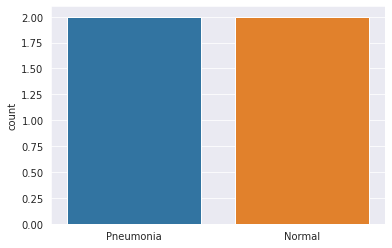

In [ ]:
#폐렴과 정상 데이터의 갯수 확인하기
l = []
for i in train:
    if(i[1] == 0):
        l.append("Pneumonia")
    else:
        l.append("Normal")
sns.set_style('darkgrid')
sns.countplot(l)  

Text(0.5, 1.0, 'NORMAL')

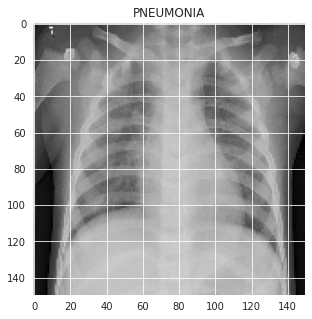

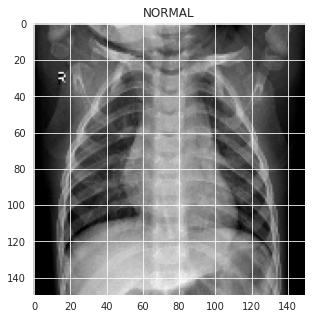

In [ ]:
#영상으로 보이기
plt.figure(figsize = (5,5))
plt.imshow(train[0][0], cmap='gray')
plt.title(labels[train[0][1]])

plt.figure(figsize = (5,5))
plt.imshow(train[-1][0], cmap='gray')
plt.title(labels[train[-1][1]])

In [ ]:
x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)
    
for feature, label in val:
    x_val.append(feature)
    y_val.append(label)

In [ ]:
# 데이터를 Normalize 0~255     0~1
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255
x_test = np.array(x_test) / 255

In [ ]:
# 딥러닝을 위해 data를 resize
x_train = x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

x_test = x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

In [ ]:
# data augmentation하기 (overfitting을 막고, 데이터셋내의 데이터 불균형도 어느 정도 해소)

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

In [ ]:
# 모델을 만들기
model = Sequential()
model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (150,150,1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Flatten())
model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 1 , activation = 'sigmoid'))
model.compile(optimizer = "rmsprop" , loss = 'binary_crossentropy' , metrics = ['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 150, 150, 32)      320       
_________________________________________________________________
batch_normalization_5 (Batch (None, 150, 150, 32)      128       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 75, 75, 64)        18496     
_________________________________________________________________
dropout_4 (Dropout)          (None, 75, 75, 64)        0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 75, 75, 64)        256       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 38, 38, 64)       

In [ ]:
#learning_rate를 줄이는 방법. 
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 5, verbose=1,factor=0.3, min_lr=0.000001)

In [ ]:
history = model.fit(datagen.flow(x_train,y_train, batch_size = 32) ,epochs = 12 , validation_data = datagen.flow(x_val, y_val) ,callbacks = [learning_rate_reduction])

Epoch 1/12
1/1 [==============================] - 3s 3s/step - loss: 1.0552 - accuracy: 0.2500 - val_loss: 0.6926 - val_accuracy: 0.5000
Epoch 2/12
1/1 [==============================] - 1s 537ms/step - loss: 4.6336 - accuracy: 0.5000 - val_loss: 0.6976 - val_accuracy: 0.5000
Epoch 3/12
1/1 [==============================] - 1s 544ms/step - loss: 17.8623 - accuracy: 0.5000 - val_loss: 0.6987 - val_accuracy: 0.5000
Epoch 4/12
1/1 [==============================] - 1s 550ms/step - loss: 0.3168 - accuracy: 0.7500 - val_loss: 0.7022 - val_accuracy: 0.5000
Epoch 5/12
1/1 [==============================] - 1s 543ms/step - loss: 6.1843e-09 - accuracy: 1.0000 - val_loss: 0.8101 - val_accuracy: 0.5000
Epoch 6/12
1/1 [==============================] - 1s 558ms/step - loss: 1.8912e-09 - accuracy: 1.0000 - val_loss: 0.9844 - val_accuracy: 0.5000

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
Epoch 7/12
1/1 [==============================] - 1s 540ms/step - loss: 6

In [ ]:
print("Loss of the model is - " , model.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

1/1 [==============================] - 0s 237ms/step - loss: 2.2083 - accuracy: 0.5000
Loss of the model is -  2.208268165588379
1/1 [==============================] - 0s 70ms/step - loss: 2.2083 - accuracy: 0.5000
Accuracy of the model is -  50.0 %


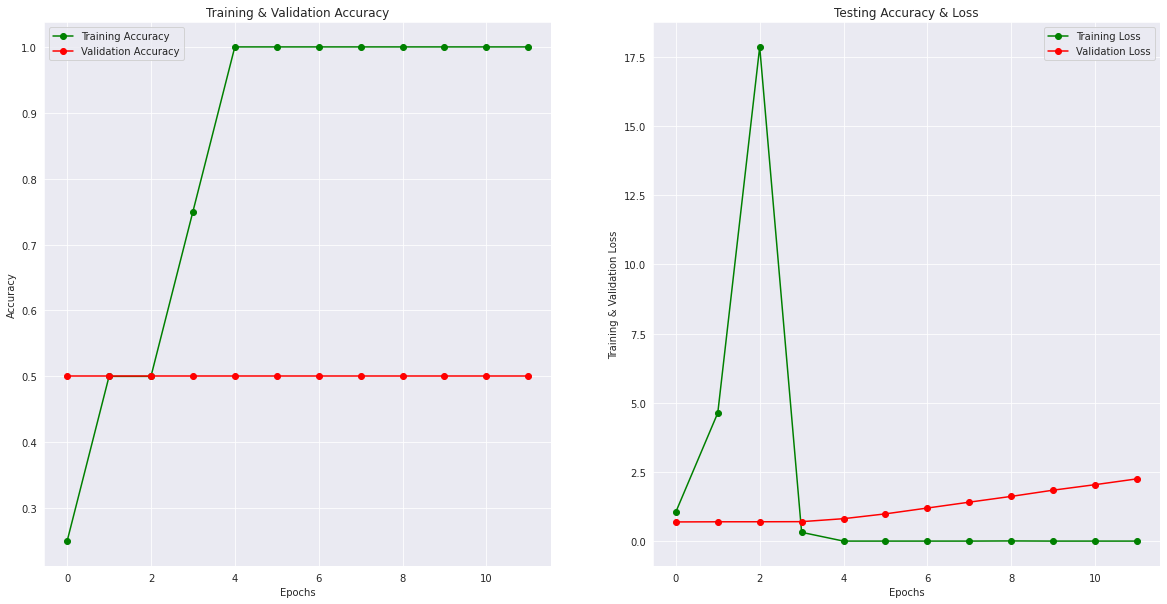

In [ ]:
epochs = [i for i in range(12)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training & Validation Loss")
plt.show()

In [ ]:
predictions = model.predict_classes(x_test)
predictions = predictions.reshape(1,-1)[0]
predictions[:15]

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


array([0, 0, 0, 0], dtype=int32)

In [ ]:
print(classification_report(y_test, predictions, target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))

                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.50      1.00      0.67         2
   Normal (Class 1)       0.00      0.00      0.00         2

           accuracy                           0.50         4
          macro avg       0.25      0.50      0.33         4
       weighted avg       0.25      0.50      0.33         4



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
cm = confusion_matrix(y_test,predictions)
cm

array([[2, 0],
       [2, 0]])

In [ ]:
cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])

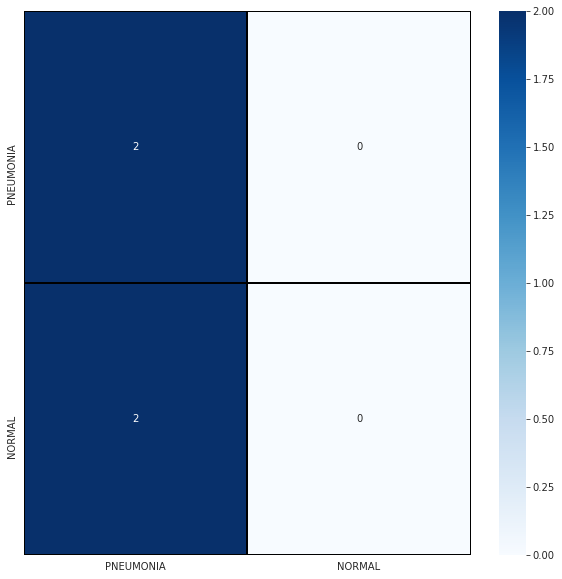

In [ ]:
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = labels,yticklabels = labels)

In [ ]:
correct = np.nonzero(predictions == y_test)[0]
incorrect = np.nonzero(predictions != y_test)[0]

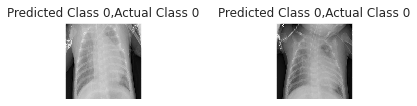

In [ ]:
i = 0
for c in correct[:6]:
    plt.subplot(3,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_test[c].reshape(150,150), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(predictions[c], y_test[c]))
    plt.tight_layout()
    i += 1

In [ ]:
#model.save(../model.h5)

## 1일차 실습해보기

위의 코드를 더 많은 데이터로 학습시켜보고, 모델을 약간 다르게도 변형시켜서 학습시켜보고 테스트 데이터에 대한 모델의 정확도가 어떻게 달라지는지 확인해보기